In [1]:
%load_ext autoreload

In [10]:
from imutils.paths import list_images
import numpy as np 
import os 
import random 
import torch.nn as nn 
import torchvision 
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [3]:
#import wandb 
#wandb.login()

In [4]:
from dataset import SegmentationDataset
from models import UNet 
from train_utils import run 

In [5]:
config_dict = {
    "batch_size": 50,
    "num_epochs": 30,
    "early_stop": 15,
    "learning_rate": 0.01, 
    "in_channels": 3,
    "out_channels": 1,
    "features": [64, 128, 256, 512],
    "project_name": "UNet_on_TGS_salt",    
}

In [6]:
data_root = os.path.expanduser('~/ml_datasets/')
path_to_dataset = os.path.join(data_root, 'TGS_salt')

IMAGE_DATASET_PATH = os.path.join(path_to_dataset, "train/images")
MASK_DATASET_PATH = os.path.join(path_to_dataset, "train/masks")

image_paths = sorted(list(list_images(IMAGE_DATASET_PATH)))
mask_paths = sorted(list(list_images(MASK_DATASET_PATH)))
print(len(image_paths), len(mask_paths))

for_train = [True if random.random() < 0.6 else False for _ in range(len(image_paths))]

train_image_paths = [x for x, f in zip(image_paths, for_train) if f]
train_mask_paths = [x for x, f in zip(mask_paths, for_train) if f]

test_image_paths = [x for x, f in zip(image_paths, for_train) if not f]
test_mask_paths = [x for x, f in zip(mask_paths, for_train) if not f]

print(len(train_image_paths), len(train_mask_paths), len(test_image_paths), len(test_mask_paths))

4000 4000
2381 2381 1619 1619


In [7]:
train_dataset = SegmentationDataset(
    image_paths=train_image_paths, 
    mask_paths=train_mask_paths, 
    transforms=torchvision.transforms.Compose(
    [torchvision.transforms.ToPILImage(),
     torchvision.transforms.ToTensor()
    ])
)

test_dataset = SegmentationDataset(
    image_paths=test_image_paths, 
    mask_paths=test_mask_paths, 
    transforms=torchvision.transforms.Compose(
    [torchvision.transforms.ToPILImage(),
     torchvision.transforms.ToTensor()
    ])
)

train_dataloader = DataLoader(train_dataset, batch_size=config_dict["batch_size"], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config_dict["batch_size"], shuffle=True)

In [8]:
history = run(train_dataloader, test_dataloader, config_dict, path_to_model='./model.pt')

finished epoch 4, train_loss: 0.3987, test_loss: 0.4233
finished epoch 9, train_loss: 0.3272, test_loss: 0.3470
finished epoch 14, train_loss: 0.2733, test_loss: 0.2820
finished epoch 19, train_loss: 0.2446, test_loss: 0.2539
finished epoch 24, train_loss: 0.2120, test_loss: 0.2429
finished epoch 29, train_loss: 0.1906, test_loss: 0.1943


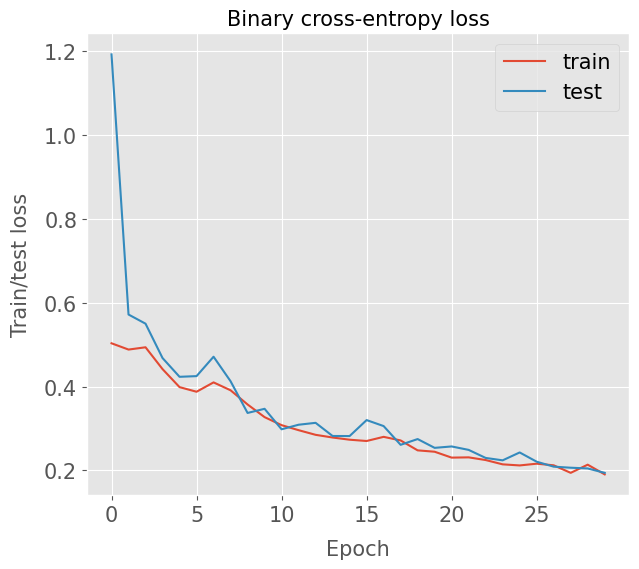

In [24]:
FONTSIZE = 15
plt.close('all')
fig, ax = plt.subplots(1, figsize=(7, 6))

ax.set_xlabel('Epoch', fontsize=FONTSIZE, labelpad=10)
ax.set_ylabel('Train/test loss', fontsize=FONTSIZE, labelpad=10)
ax.set_xticks(np.arange(0, len(history['train']['loss']), 5))
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(FONTSIZE)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(FONTSIZE)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_rotation(45)

ax.set_title('Binary cross-entropy loss', fontsize=FONTSIZE)

vals = history['train']['loss']
ax.plot(range(len(vals)), vals, label='train')

vals = history['test']['loss']
ax.plot(range(len(vals)), vals, label='test')

ax.legend(loc='best', fontsize=FONTSIZE)

